In [1]:
import copy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch import nn
from sklearn.metrics import accuracy_score

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from cassava.utils import *
from cassava.transforms import get_train_transforms, get_test_transforms

# Prepare data

In [4]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-17 13:49:06,274 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [13]:
train_images_lmdb = context.catalog.load('train_images_lmdb')

2020-12-17 13:49:38,214 - kedro.io.data_catalog - INFO - Loading data from `train_images_lmdb` (KedroImageLMDBDataSet)...


In [14]:
train_labels = context.catalog.load('train_labels')

2020-12-17 13:49:39,003 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [15]:
parameters = context.catalog.load('parameters')

2020-12-17 13:49:39,225 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [16]:
parameters

{'seed': 42,
 'cv_splits': 4,
 'cv_models_dir': 'data/06_models/cv_folds',
 'validation_size': 0.15,
 'data_loader_workers': 6,
 'classifier': {'gpus': -1,
  'batch_size': 10,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'early_stop_patience': 4,
  'reduce_lr_on_pleteau_patience': 2,
  'save_top_k_checkpoints': 1,
  'checkpoints_dir': 'data/06_models/classifier/checkpoints'},
 'byol': {'gpus': -1,
  'batch_size': 10,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'reduce_lr_on_pleteau_patience': 1,
  'weight_decay': 0.0001,
  'limit_train_batches': 300,
  'limit_val_batches': 1,
  'accumulate_grad_batches': 4,
  'early_stop_patience': 6,
  'from_checkpoint': 0,
  'on_test': {'auto_lr_find': 1, 'max_epochs': 10, 'early_stop_patience': 2}}}

In [17]:
res = context.pipelines['train'].nodes[0].run({'train_labels': train_labels, 'parameters': parameters})
train_indices = np.array(res['train_indices'])
val_indices = np.array(res['val_indices'])

2020-12-17 13:49:39,916 - kedro.pipeline.node - INFO - Running node: split_data: split_data([parameters,train_labels]) -> [train_indices,val_indices]


In [18]:
train_indices.shape, val_indices.shape

((18187,), (3210,))

In [19]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [40]:
raw_transforms = A.Compose([
        A.ToFloat(max_value=1.0),
        A.Resize(64, 64),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
])

def get_train_transforms():
    return A.Compose([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=1),
        A.ToFloat(max_value=1.0),
        A.RandomResizedCrop(256, 256, scale=(0.3, 0.9)),
        A.Resize(64, 64),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


def get_test_transforms():
    return A.Compose([
        A.ToFloat(max_value=1.0),
        A.CenterCrop(300, 300),
        A.Resize(64, 64),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [41]:
train_transform, val_transform = get_train_transforms(), get_test_transforms()

train_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_lmdb, indices=train_indices),
                                      transform=train_transform)

val_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_lmdb, indices=val_indices),
                                transform=val_transform)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=parameters['classifier']['batch_size'],
                                                num_workers=parameters['data_loader_workers'],
                                                shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset, num_workers=parameters['data_loader_workers'], batch_size=parameters['classifier']['batch_size'])

In [42]:
raw_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_lmdb, indices=list(range(len(train_images_torch)))), transform=raw_transforms)
augmented_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_lmdb, indices=list(range(len(train_images_torch)))), transform=get_train_transforms())
test_aug_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_lmdb, indices=list(range(len(train_images_torch)))), transform=get_test_transforms())

3


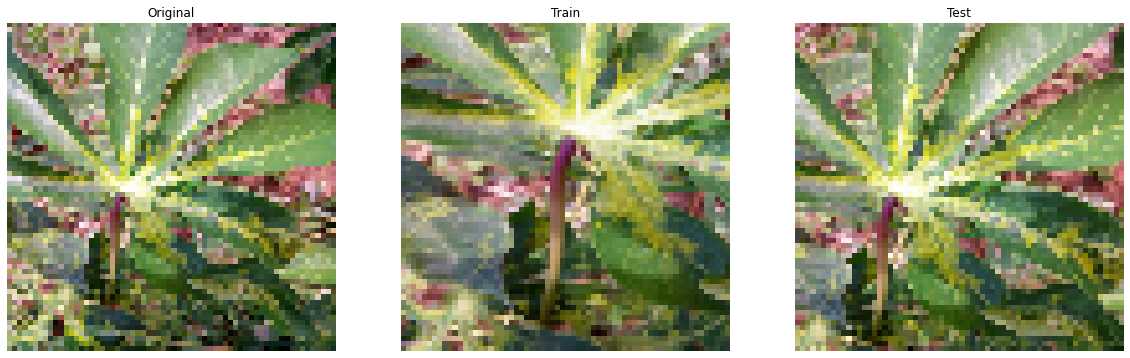

In [45]:
idx = np.random.choice(range(len(train_images_torch)))
raw_image, label = raw_dataset[idx]
aug_image, _ = augmented_dataset[idx]
test_aug_image, _ = test_aug_dataset[idx]

print(label)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plot_image(unnorm(raw_image))
plt.title('Original')
plt.subplot(1, 3, 2)
plot_image(unnorm(aug_image))
plt.title('Train')
plt.subplot(1, 3, 3)
plot_image(unnorm(test_aug_image))
plt.title('Test')
plt.show()

In [46]:
raw_image.shape, aug_image.shape, test_aug_image.shape

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]), torch.Size([3, 64, 64]))

# Define model

In [256]:
#!pip install pytorch-lightning-bolts

In [47]:
from pl_bolts.models.autoencoders import AE

# Train

In [125]:
def plot_random_img_reconstruction(model):
    model.eval()
    random_idx = np.random.choice(range(len(test_aug_dataset)))
    image, label = test_aug_dataset[random_idx]
    
    reconstruction = model(image.unsqueeze(0))[0].detach().cpu()
    reconstruction = torch.Tensor(reconstruction)
    
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plot_image(unnorm(image), label=f"true: {label}")
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plot_image(unnorm(reconstruction))
    plt.title('Reconstructed')
    plt.show()
    

In [126]:
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from argparse import Namespace

In [395]:
class Autoencoder(pl.LightningModule):
    def __init__(self, hparams = None):
        super().__init__()
        
        self.hparams = hparams or Namespace()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 18, 3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),
            nn.Conv2d(18, 32, 3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.Tanh(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 2, stride=2),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, 2, stride=2),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, 1, stride=1),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, 1, stride=1),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, 1, stride=1),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 18, 1, stride=1),
            nn.Tanh(),
            nn.ConvTranspose2d(18, 18, 1, stride=1),
            nn.Tanh(),
            nn.ConvTranspose2d(18, 18, 1, stride=1),
            nn.Tanh(),
            nn.ConvTranspose2d(18, 8, 1, stride=1),
            nn.Tanh(),
            nn.ConvTranspose2d(8, 3, 1, stride=1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.hparams.lr or self.hparams.learning_rate,
                                      weight_decay=self.hparams.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  patience=self.hparams.reduce_lr_on_pleteau_patience,
                                                                  verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': lr_scheduler,
            'monitor': 'train_loss',
            'interval': 'epoch',
            'frequency': 1
        }
    
    def training_step(self, batch, batch_idx):
        criterion = nn.MSELoss()
        
        x, _ = batch
        x_hat = self(x)
        loss = criterion(x_hat, x)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def on_epoch_end(self):
        plot_random_img_reconstruction(self)

In [396]:
Autoencoder().encoder(torch.zeros(2, 3, 64, 64)).shape

torch.Size([2, 32, 16, 16])

In [397]:
Autoencoder()(torch.zeros(2, 3, 64, 64)).shape

torch.Size([2, 3, 64, 64])

In [398]:
ae_params = Namespace(**{
    'limit_train_batches': 300, 
    'lr': 0.001,
    'auto_lr_find': 1,
    'weight_decay': 0.001,
    'reduce_lr_on_pleteau_patience': 2,
})

In [399]:
model = Autoencoder(hparams=ae_params)

In [400]:
# ae_params.lr = ae_params.lr / 10

In [401]:
trainer = Trainer.from_argparse_args(
    ae_params,
    reload_dataloaders_every_epoch = True,
    terminate_on_nan = True,
)

GPU available: True, used: False


2020-12-17 14:44:14,709 - lightning - INFO - GPU available: True, used: False


TPU available: False, using: 0 TPU cores


2020-12-17 14:44:14,714 - lightning - INFO - TPU available: False, using: 0 TPU cores


In [402]:
# lr_finder = trainer.tuner.lr_find(model,
#                                   train_dataloader=train_data_loader,
#                                   val_dataloaders=[val_data_loader])
# plt.figure()
# plt.title('LR finder results')
# lr_finder.plot(suggest=True)
# plt.show()
# new_lr = lr_finder.suggestion()
# model.hparams.lr = new_lr
# new_lr


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 79.7 K
1 | decoder | Sequential | 12.9 K


2020-12-17 14:44:15,946 - lightning - INFO - 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 79.7 K
1 | decoder | Sequential | 12.9 K


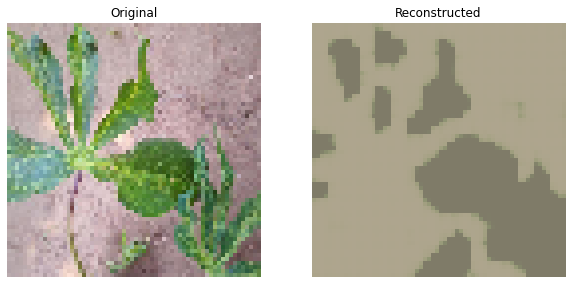

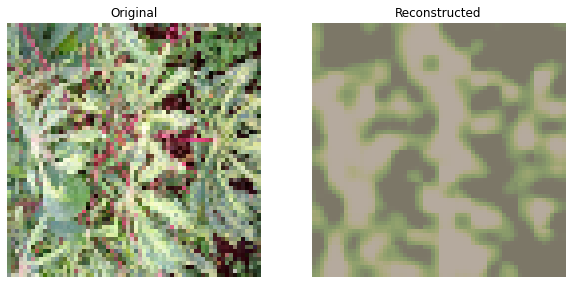

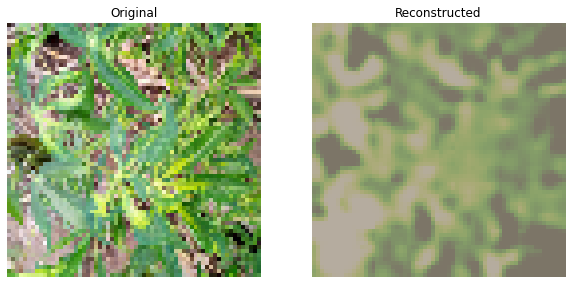

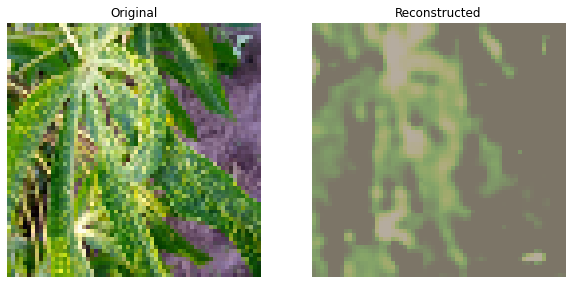

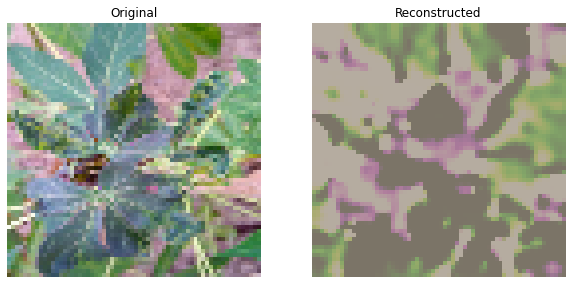

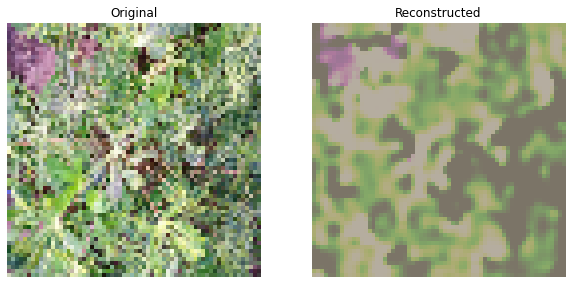

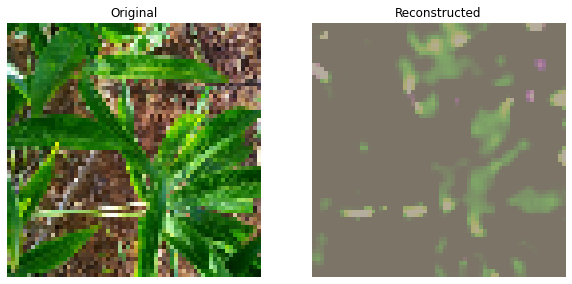

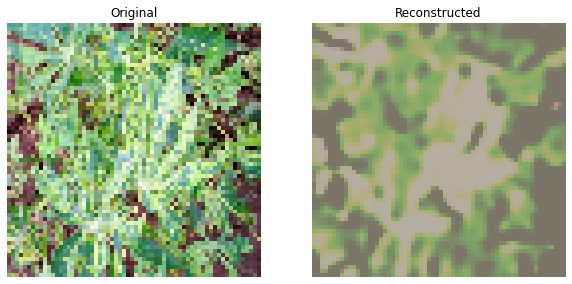

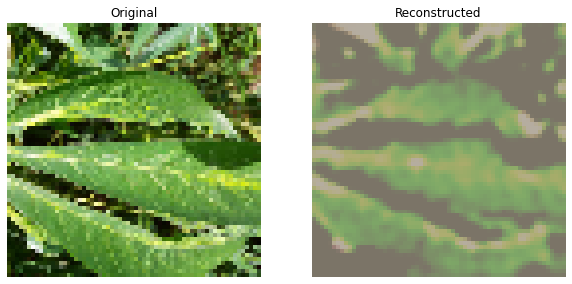

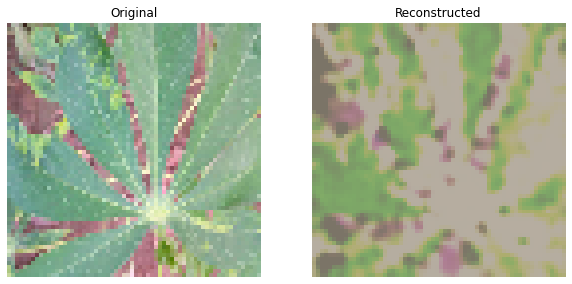

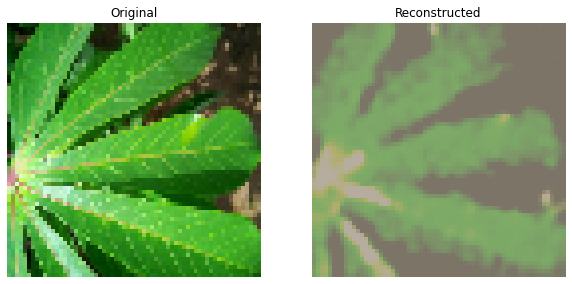

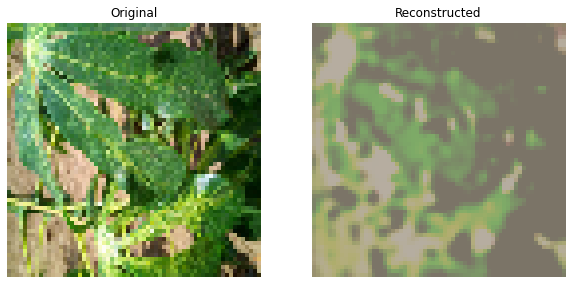

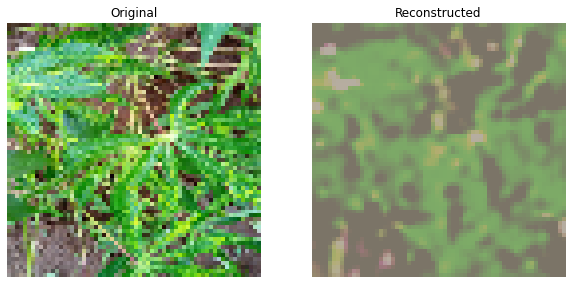

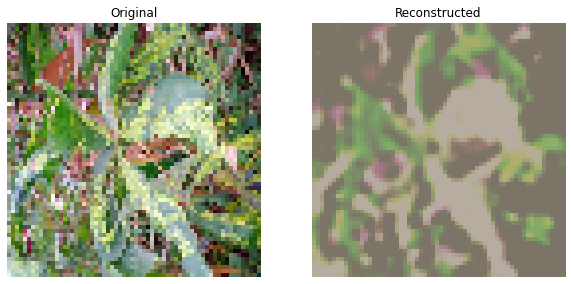

In [ ]:
trainer.fit(model, train_data_loader, val_data_loader)

In [ ]:
model = model.eval()

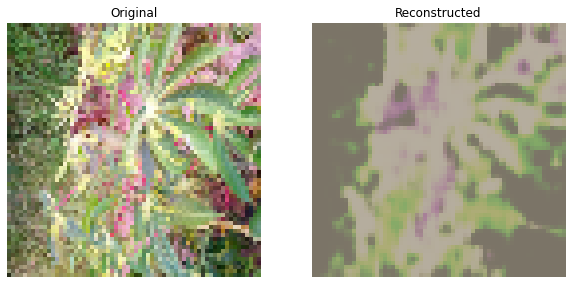

In [275]:
plot_random_img_reconstruction(model)